In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import sklearn.metrics as metrics
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import *
import seaborn as sns


In [2]:
df=pd.read_csv("data/bank-additional-full.csv",sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
#X랑 y 나누기 
y=df['y']
X=df.drop(columns=['y'])
y

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: object

In [4]:
#split the dataset into training & testing set
def split(X,y,test_size):
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=0)
    return x_train, x_test, y_train, y_test

In [5]:
#df 중에서 원하는 columns만 one_hot encoding
def onehotEncoding(df,columns):
    onehot=pd.get_dummies(df, prefix=columns)
    return onehot

In [6]:
def labelEncoding(df, columns):
    
    # columns가 y인경우에는 시리즈 형태
    if len(columns)==1 and columns=="y":
        labelX=preprocessing.LabelEncoder()
        df=labelX.fit_transform(df)
    else:
        for i in columns:
            labelX=preprocessing.LabelEncoder()
            df.loc[:,i]=labelX.fit_transform(df.loc[:,i])
    return df

In [7]:
#solver: liblinear, lbfgs, sag
def runLogistic(x_train,x_test,y_train,y_test,solver,max_iter):
    logistic=LogisticRegression(solver=solver, max_iter=max_iter)
    logistic.fit(x_train,y_train)
    score=logistic.score(x_test,y_test)
    predict=logistic.predict(x_test)
    recall=metrics.recall_score(y_test,predict)
    return recall, score

In [8]:
#penalty: l1,l2,elasticnet
# run SGDClassifier
def runSGDClassifier(x_train,x_test,y_train,y_test,loss,max_iter,penalty):
    if loss=="logistic":
        loss="log"
    clf=SGDClassifier(loss=loss, penalty=penalty,max_iter=max_iter)
    clf.fit(x_train,y_train)
    predict=clf.predict(x_test)
    score=clf.score(x_test,y_test)
    recall=metrics.recall_score(y_test,predict)
    return recall, score

In [9]:
#kernel "linear","rbf","sigmoid","poly"
def runSVM(x_train,x_test,y_train,y_test,C,kernel,gamma):
    clf=svm.SVC(C=C,kernel=kernel,gamma=gamma)
    clf.fit(x_train,y_train)
    score=clf.score(x_test,y_test)
    predict=clf.predict(x_test)
    recall=metrics.recall_score(y_test,predict)
    return recall, score

In [10]:
def runNB(x_train,x_test,y_train,y_test):
    clf=GaussianNB()
    clf.fit(x_train,y_train)
    score=clf.score(x_test,y_test)
    predict=clf.predict(x_test)
    recall=metrics.recall_score(y_test,predict)
    return recall, score

In [11]:
#카테고리컬 데이터 뽑는거
object_feature = [col for col in X.columns if X[col].dtypes == 'object' ]

#카테고릴컬 onehot encoding , 타겟은 라벨 인코딩
X=onehotEncoding(X,object_feature)
y=labelEncoding(y,"y")

In [12]:
x_train,x_test,y_train,y_test=split(X,y,0.3)
#일단은 그냥 이렇게 짯는데, 그리디 서치 같은거 쓰면 좋을듯!
for solver in ["liblinear","lbfgs","sag"]:
    for max_iter in [50,100,200]:
        print(solver, max_iter,runLogistic(x_train,x_test,y_train,y_test,solver,max_iter))


liblinear 50 (0.41354466858789624, 0.9113862588006798)
liblinear 100 (0.41354466858789624, 0.9113862588006798)
liblinear 200 (0.41354466858789624, 0.9113862588006798)
lbfgs 50 (0.31484149855907784, 0.9057214534272072)
lbfgs 100 (0.4034582132564842, 0.9113862588006798)
lbfgs 200 (0.4250720461095101, 0.9106579266812334)
sag 50 (0.33069164265129686, 0.9060451565914057)
sag 100 (0.329971181556196, 0.9061260823824553)
sag 200 (0.3371757925072046, 0.9065307113377034)


In [62]:
probs = []
name = []

In [63]:
runLogistic(x_train,x_test,y_train,y_test,"liblinear",50)
probs.append(max(runLogistic(x_train,x_test,y_train,y_test,"liblinear",50)))
name.append('Logistic')

In [64]:
runNB(x_train,x_test,y_train,y_test)
probs.append(max(runNB(x_train,x_test,y_train,y_test)))
name.append('NB')

In [33]:
"""
#너무 오래 걸려.... 나중에 한번 맘먹고 돌려야될듯
for C in [0.1,1.0,10.0]:
    for kernel in ["linear","rbf","sigmoid","poly"] :
        for gamma in [10,100]:
            print(runSVM(x_train,x_test,y_train,y_test,C,kernel,gamma))
"""

'\n#너무 오래 걸려.... 나중에 한번 맘먹고 돌려야될듯\nfor C in [0.1,1.0,10.0]:\n    for kernel in ["linear","rbf","sigmoid","poly"] :\n        for gamma in [10,100]:\n            print(runSVM(x_train,x_test,y_train,y_test,C,kernel,gamma))\n'

In [65]:
# SVM 돌리면 바꿈
probs.append(0.5)
name.append('SVM')

In [66]:
print(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"l1"))
print(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"l2"))
print(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"elasticnet"))

probs.append(max(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"l1")))
probs.append(max(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"l2")))
probs.append(max(runSGDClassifier(x_train,x_test,y_train,y_test,"logistic",5,"elasticnet")))

name.append('SGD&l1')
name.append('SGD&l2')
name.append('SGD&elastic')

(0.6117900790797987, 0.759698275862069)
(0.7828900071890726, 0.7744252873563219)
(0.9345794392523364, 0.7151580459770115)


In [67]:
runNB(x_train,x_test,y_train,y_test)
probs.append(max(runNB(x_train,x_test,y_train,y_test)))
name.append('NB')

In [17]:
sm=SMOTE(ratio="auto",kind="regular")
#X_samp, y_samp = TomekLinks(random_state=0).fit_sample(x_train, y_train)
X_samp, y_samp = SMOTE(random_state=4).fit_sample(x_train, y_train)

In [18]:
count=0
count1=0
for i in range(len(y_samp)):
    if y_samp[i]==0:
        count+=1

for i in range(len(y_train)):
    if y_train[i]==0:
        count1+=1

print(count,count1)

25579 25579


In [19]:
x_train

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
31880,37,195,1,999,0,-1.8,92.893,-46.2,1.327,5099.1,...,0,0,0,0,1,0,0,0,1,0
38177,54,214,1,999,0,-3.4,92.431,-26.9,0.754,5017.5,...,1,0,0,0,1,0,0,0,1,0
2459,49,813,2,999,0,1.1,93.994,-36.4,4.856,5191.0,...,0,0,0,0,0,1,0,0,1,0
756,30,51,3,999,0,1.1,93.994,-36.4,4.856,5191.0,...,0,0,0,0,0,0,1,0,1,0
11275,23,359,1,999,0,1.4,94.465,-41.8,4.961,5228.1,...,0,0,0,0,1,0,0,0,1,0
29677,49,334,1,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,0,1,0,0,0,0,1,0
13016,27,1061,4,999,0,1.4,93.918,-42.7,4.962,5228.1,...,0,0,0,0,0,1,0,0,1,0
1518,38,277,3,999,0,1.1,93.994,-36.4,4.855,5191.0,...,0,0,0,0,1,0,0,0,1,0
34983,46,39,1,999,1,-1.8,92.893,-46.2,1.250,5099.1,...,0,0,1,0,0,0,0,1,0,0
24965,47,103,1,999,1,-0.1,93.200,-42.0,4.153,5195.8,...,0,0,0,0,0,1,0,1,0,0


In [20]:
def randomUnderSampling(X,y):
    rus = RandomUnderSampler(random_state=0)
    rus.fit(X,y)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

In [21]:
def randomOverSampling(X,y):
    ros = RandomOverSampler(random_state=0)
    ros.fit(X, y)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return x_resampled, y_resampled

In [68]:
x_sam,y_sam=randomUnderSampling(X,y)
x_train,x_test,y_train,y_test=split(x_sam,y_sam,0.3)
runLogistic(x_train,x_test,y_train,y_test,"liblinear",50)

probs.append(max(runLogistic(x_train,x_test,y_train,y_test,"liblinear",50)))
name.append('underLogistic')

In [69]:
print(probs)
print(name)

[0.8878504672897196, 0.728448275862069, 0.5, 0.7647270114942529, 0.7553879310344828, 0.5290948275862069, 0.728448275862069, 0.8878504672897196]
['Logistic', 'NB', 'SVM', 'SGD&l1', 'SGD&l2', 'SGD&elastic', 'NB', 'underLogistic']


In [107]:
def barPlot(probs, name):
    sns.barplot(name, probs, alpha=0.4)
    plt.show()

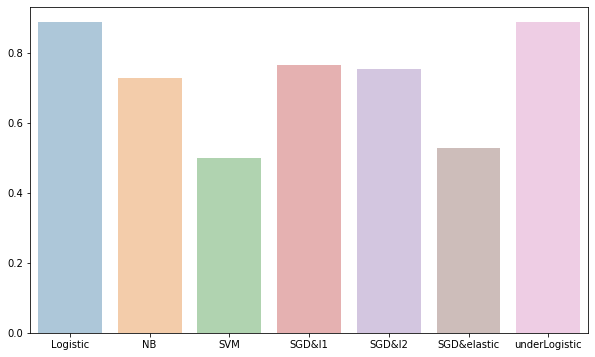

In [108]:
plt.figure(figsize = (10,6))
barPlot(probs, name)